In [ ]:
!conda install pandas -y

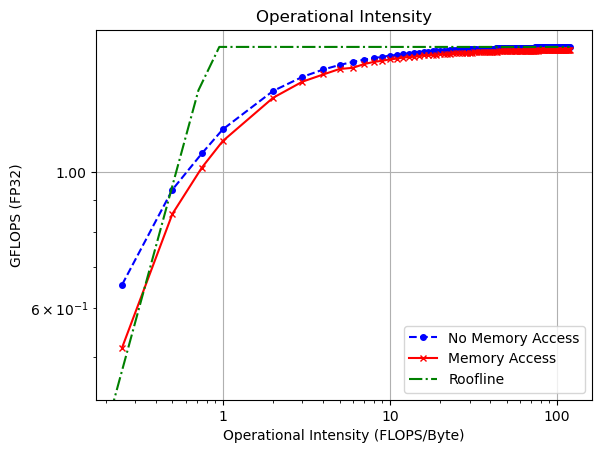

In [14]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import numpy as np
import matplotlib.pyplot as plt

csv_file = "operational_intensity_ac6_hp_no_mem.csv"
data = pd.read_csv(csv_file)

x_column = data.columns[0]
y_column = data.columns[1]
csv_file_2 = "operational_intensity_ac6_hp_mem.csv"
data_2 = pd.read_csv(csv_file_2)

# Roofline Model
x_values = np.linspace(0, max(data[x_column]), 500)
y_values = np.minimum(1.9 * x_values, 1.6) # min(1.9x, 1.6)

plt.xscale('log')
plt.yscale('log')
plt.title("Operational Intensity")
plt.xlabel("Operational Intensity (FLOPS/Byte)")
plt.ylabel("GFLOPS (FP32)")
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.plot(data[x_column], data[y_column], marker='o', linestyle='--', color='b', markersize=4)
plt.plot(data_2[x_column], data_2[y_column], marker='x', linestyle='-', color='r', markersize=4)
plt.plot(x_values, y_values, linestyle='-.', color='g')
plt.legend(['No Memory Access', 'Memory Access', 'Roofline'])
plt.grid(visible=True)
plt.show()

# m
Insgesamt:
- 128 Bit (= 16 Byte) für A laden
- 196 Bit (= 24 Byte) für B laden
- 6x VFMA (jeweils 8 FLOP) => 48 FLOP
- somit $48/40=1.2$ Operational Intensity

```asm
gemm_asm_4x6_loop:
    /* Load A */
    vldrw.f32 q6, [r0] // 128 Bit laden
    add r0, r0, r3, lsl #2 // Einmal Länge aufaddieren

    add r6, r1, r3, lsl #3 // 2len
    ldr r7, [r6] // load b[2len] -> 32 Bit
    ldr r8, [r6, r3, lsl #2]  -> 32 Bit
    add r6, r6, r3, lsl #3 // 2len + 2len
    ldr r9, [r6] -> 32 Bit
    vfma.f32 q2, q6, r7 -> 8 FLOP
    vfma.f32 q3, q6, r8 -> 8 FLOP
    vfma.f32 q4, q6, r9 -> 8 FLOP

    // load b[5len] 
    ldr r8, [r6, r3, lsl #2] -> 32 Bit
    vfma.f32 q5, q6, r8 -> 8 FLOP

    ldr r7, [r1, r3, lsl #2] // load b[len] -> 32 Bit
    ldr r8, [r1], #4 // load b[0] and rewrite for new k -> 32 Bit
    vfma.f32 q0, q6, r8 -> 8 FLOP
    vfma.f32 q1, q6, r7 -> 8 FLOP

    le lr, gemm_asm_4x6_loop
```


# Roofline
- $P = \min\{\pi, \beta \times I\}$
- $\pi$... peak performance
- $\beta$... peak bandwidth
- $I$... arithmetic intensity